#About This Project 

**Context**

Understanding what will be the Burn Rate for the employee working in an organization based on the current pandemic situation where work from home is a boon and a bane. How are employees' Burn Rate affected based on various conditions provided?

**Content**

Globally, World Mental Health Day is celebrated on October 10 each year. The objective of this day is to raise awareness about mental health issues around the world and mobilize efforts in support of mental health. According to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide. These days when the world is suffering from a pandemic situation, it becomes really hard to maintain mental fitness.

https://www.kaggle.com/datasets/blurredmachine/are-your-employees-burning-out

#Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Dataset

In [3]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/dibimbing/project/Talent Showcase/burnout/train.csv')
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


###Feature
* Employee ID: The unique ID allocated for each employee (Drop them)

* Date of Joining: The date-time when the employee has joined the organization (convert to datetimes)

* Gender: The gender of the employee (Male/Female)
Company Type: The type of company where the employee is working (Service/Product)

* WFH Setup Available: Is the work from home facility available for the employee (Yes/No)

* Designation: The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.

* Resource Allocation: The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)

* Mental Fatigue Score: The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

###Target
* Burn Rate: The value we need to predict for each employee telling the rate of Bur out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

#  Preliminary Look and Data Cleansing

In [4]:
df.shape

(22750, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [6]:
#convert datetimes
df["Date of Joining"] =  pd.to_datetime(df["Date of Joining"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Employee ID           22750 non-null  object        
 1   Date of Joining       22750 non-null  datetime64[ns]
 2   Gender                22750 non-null  object        
 3   Company Type          22750 non-null  object        
 4   WFH Setup Available   22750 non-null  object        
 5   Designation           22750 non-null  float64       
 6   Resource Allocation   21369 non-null  float64       
 7   Mental Fatigue Score  20633 non-null  float64       
 8   Burn Rate             21626 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1.6+ MB


##Missing Value & Duplicated check

In [7]:
# number of missing values per column
df.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [8]:
# percentage version
df.isna().sum() * 100 / len(df)

Employee ID             0.000000
Date of Joining         0.000000
Gender                  0.000000
Company Type            0.000000
WFH Setup Available     0.000000
Designation             0.000000
Resource Allocation     6.070330
Mental Fatigue Score    9.305495
Burn Rate               4.940659
dtype: float64

In [9]:
# number of duplicated data
df.duplicated().sum()

0

* Missing value on target will be drop
* Since number of rows with missing values are big in proportion (> 5%), we can impute them.
* No duplicated data

###Drop missing value on target

In [10]:
#Drop missing value on target
df = df.dropna(subset=['Burn Rate'])
df.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1278
Mental Fatigue Score    1945
Burn Rate                  0
dtype: int64

### Impute missing value on features

In [11]:
for column in ['Resource Allocation', 'Mental Fatigue Score']:
      df[column] = df[column].fillna(df[column].median())

In [12]:
#sanity check
df.isna().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

#Data Understanding

In [13]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Employee ID           21626 non-null  object        
 1   Date of Joining       21626 non-null  datetime64[ns]
 2   Gender                21626 non-null  object        
 3   Company Type          21626 non-null  object        
 4   WFH Setup Available   21626 non-null  object        
 5   Designation           21626 non-null  float64       
 6   Resource Allocation   21626 non-null  float64       
 7   Mental Fatigue Score  21626 non-null  float64       
 8   Burn Rate             21626 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1.6+ MB


##Calculate the number of values for each categorical data

In [15]:
df_object = df.select_dtypes('object')
for col in df_object:
	print(f'Column: {col}','\n')
	print(df_object[col].value_counts(),'\n')

Column: Employee ID 

fffe32003000360033003200    1
fffe33003400300033003900    1
fffe3600390036003900        1
fffe3300340037003200        1
fffe33003300300034003300    1
                           ..
fffe3100370038003800        1
fffe31003400330031003100    1
fffe3600310030003500        1
fffe32003000350036003400    1
fffe3400350031003800        1
Name: Employee ID, Length: 21626, dtype: int64 

Column: Gender 

Female    11349
Male      10277
Name: Gender, dtype: int64 

Column: Company Type 

Service    14124
Product     7502
Name: Company Type, dtype: int64 

Column: WFH Setup Available 

Yes    11685
No      9941
Name: WFH Setup Available, dtype: int64 



**Unique Value**
* Column: Employee ID (drop)

**2 Value**: 
* gender
* company type
* WFH Setup Available


In [16]:
#drop Employee ID
df = df.drop(['Employee ID'], axis = 1)

In [17]:
df.head()

,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


## Statistical summary

In [18]:
# group column names based on type

cats = ['Gender','Company Type','WFH Setup Available']

nums = ['Designation','Resource Allocation','Mental Fatigue Score','Burn Rate']

In [19]:
# numerical statistical sumary
df[nums].describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,21626.000000,21626.000000,21626.000000,21626.000000
mean,2.178766,4.455239,5.745154,0.452005
std,1.135428,1.990000,1.833016,0.198226
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.700000,0.310000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,6.900000,0.590000
max,5.000000,10.000000,10.000000,1.000000


Observation:
* Overall, the minimum and maximum values make sense for each column
* Mean ~ 50% (Median) column, indicating somewhat a symmetrical distribution

In [20]:
# describe method on categorical data
df[cats].describe()

,Gender,Company Type,WFH Setup Available
count,21626,21626,21626
unique,2,2,2
top,Female,Service,Yes
freq,11349,14124,11685


observation : 
* gender column is dominated by women
* The Company Type column is dominated by service
* WFH Setup Available column is dominated by Yes

In [21]:
#Date of joining
df['Date of Joining'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                   21626
unique                    366
top       2008-05-21 00:00:00
freq                       83
first     2008-01-01 00:00:00
last      2008-12-31 00:00:00
Name: Date of Joining, dtype: object

observation : 
* employee joined the company from the range 2008-01-01 to 2008-12-31
* since they joined in the same year, I decided to drop this column

In [22]:
#drop Date of Joining
df = df.drop(['Date of Joining'], axis = 1)

In [23]:
df.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,Female,Service,No,2.0,3.0,3.8,0.16
1,Male,Service,Yes,1.0,2.0,5.0,0.36
2,Female,Product,Yes,2.0,4.0,5.8,0.49
3,Male,Service,Yes,1.0,1.0,2.6,0.20
4,Female,Service,No,3.0,7.0,6.9,0.52


#Exploratory Data Analysis

##Univariate Analysis

### Boxplot to detect outliers

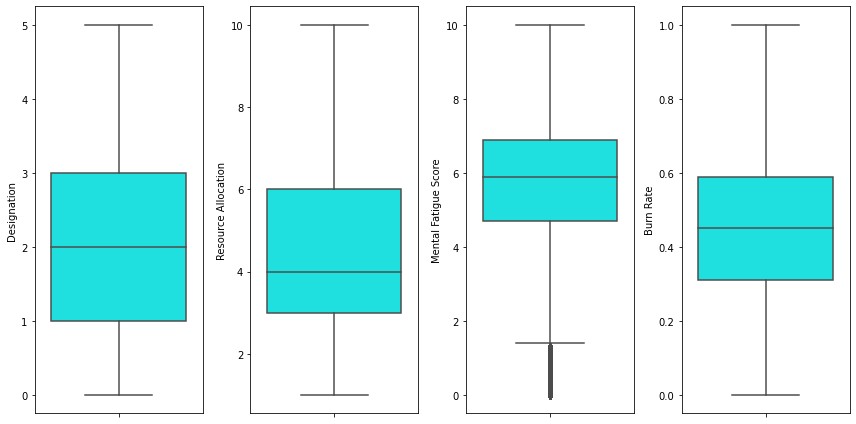

In [24]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = nums
for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='cyan')
    plt.tight_layout()

observation : Observation:
1. There is an outlier in the `Mental Fatigue Score` column. But since the value isn't too extreme, there's no need to consider

### KDE plot for knowing the distribution form

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

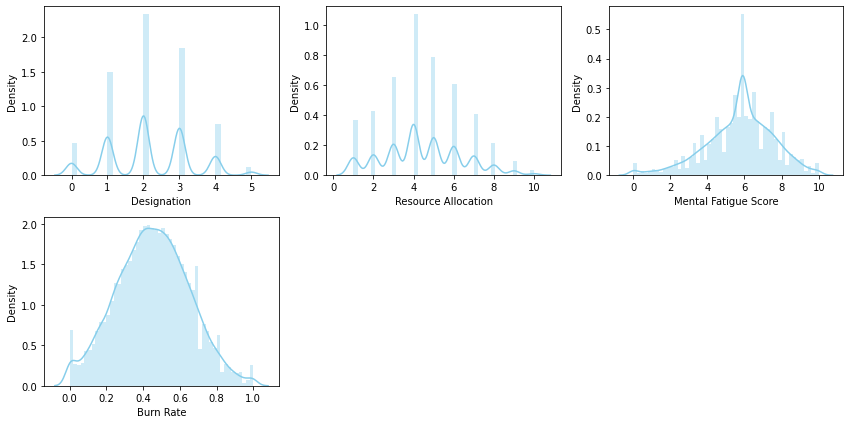

In [25]:
plt.figure(figsize=(12,6))

features = nums
for i in range(0, len(features)):
    plt.subplot(2, len(features)//2 + 1, i+1)
    #plt.subplot(1, len(features), i+1)
    sns.distplot(x=df[features[i]], color='skyblue')
    plt.xlabel(features[i])
    plt.tight_layout()

## Bivariate Analysis

In [26]:
df.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,Female,Service,No,2.0,3.0,3.8,0.16
1,Male,Service,Yes,1.0,2.0,5.0,0.36
2,Female,Product,Yes,2.0,4.0,5.8,0.49
3,Male,Service,Yes,1.0,1.0,2.6,0.20
4,Female,Service,No,3.0,7.0,6.9,0.52


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21626 entries, 0 to 22749
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                21626 non-null  object 
 1   Company Type          21626 non-null  object 
 2   WFH Setup Available   21626 non-null  object 
 3   Designation           21626 non-null  float64
 4   Resource Allocation   21626 non-null  float64
 5   Mental Fatigue Score  21626 non-null  float64
 6   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.3+ MB


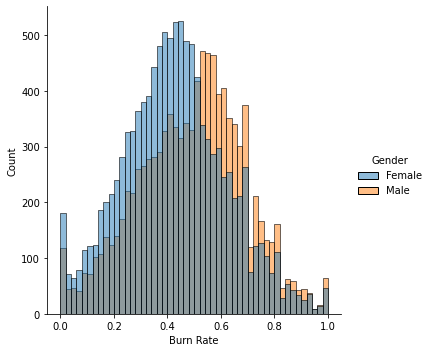

In [28]:
#Gender
sns.displot(x=df['Burn Rate'],
            hue=df['Gender'])

Observation : no gender dominates the higher burn rate. All genders have the same probability of burn rate

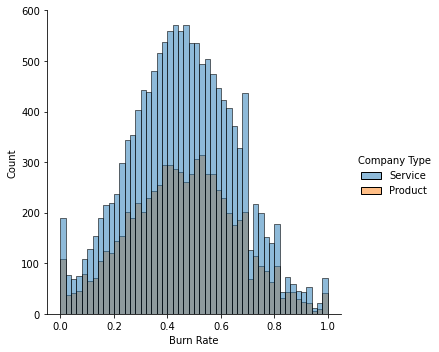

In [29]:
#Company Type
sns.displot(x=df['Burn Rate'],
            hue=df['Company Type'])

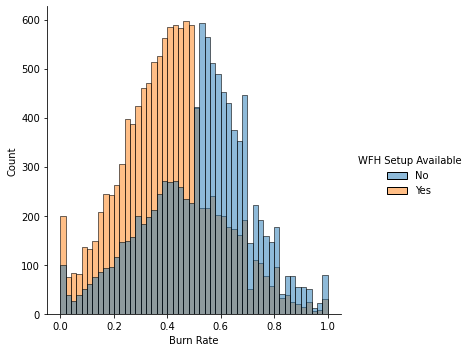

In [30]:
#WFH Setup Available
sns.displot(x=df['Burn Rate'],
            hue=df['WFH Setup Available'])

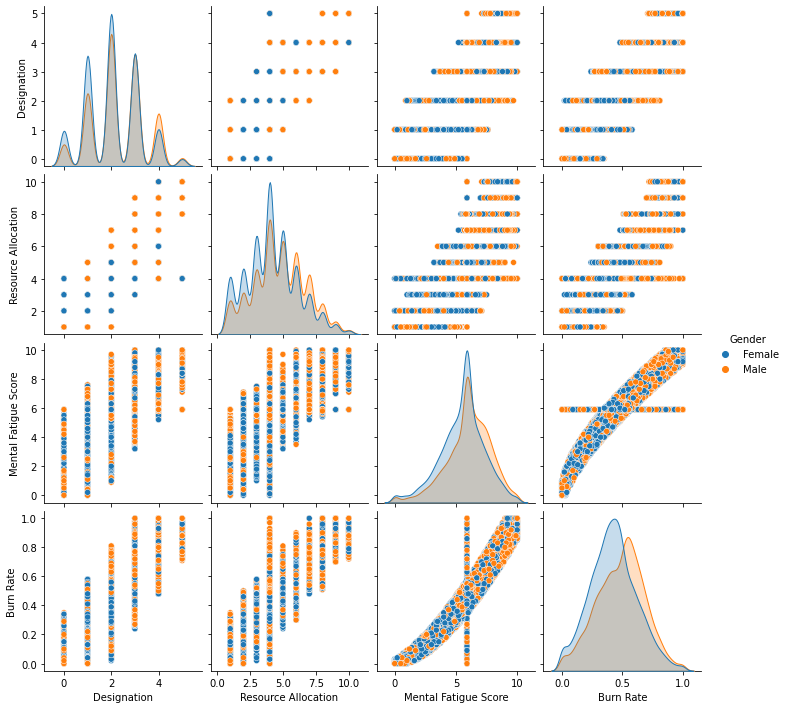

In [31]:
# pairplot of the data
sns.pairplot(df, hue='Gender')

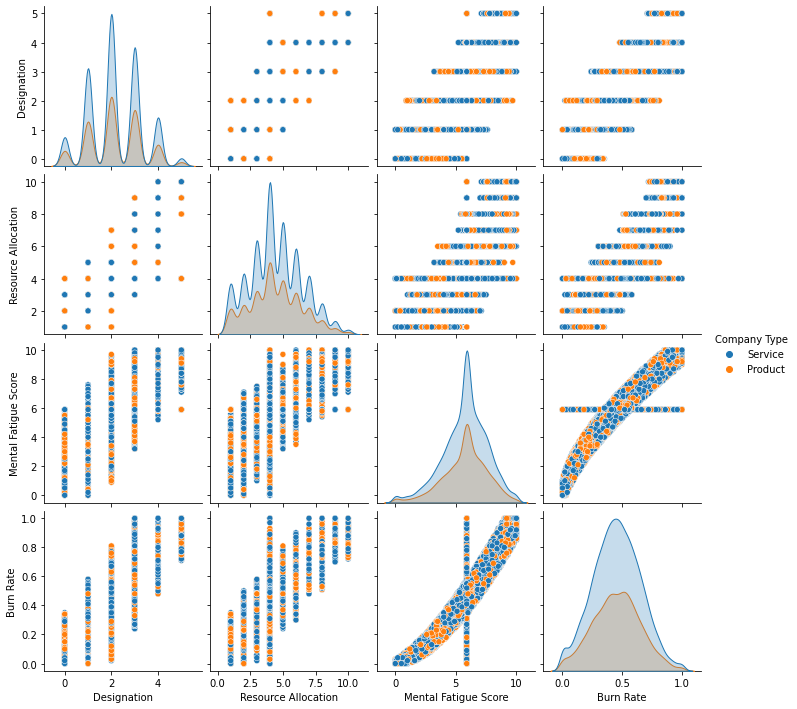

In [32]:
# pairplot of the data
sns.pairplot(df, hue='Company Type')

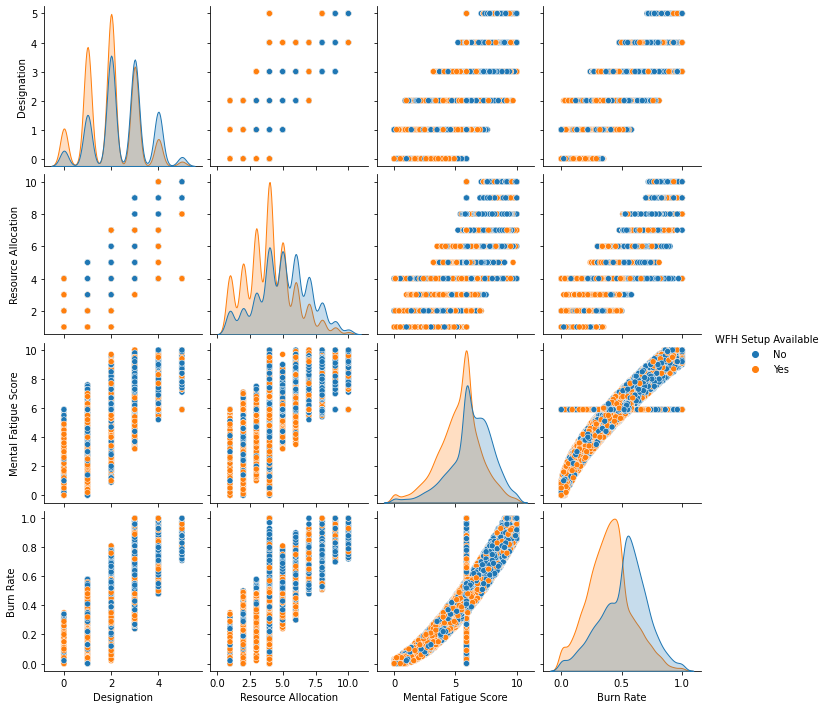

In [33]:
# pairplot of the data
sns.pairplot(df, hue='WFH Setup Available')

#Handling Category

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21626 entries, 0 to 22749
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                21626 non-null  object 
 1   Company Type          21626 non-null  object 
 2   WFH Setup Available   21626 non-null  object 
 3   Designation           21626 non-null  float64
 4   Resource Allocation   21626 non-null  float64
 5   Mental Fatigue Score  21626 non-null  float64
 6   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.3+ MB


**2 Value need to Label Encoding**: 
* gender
* company type
* WFH Setup Available


In [35]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x== 'Female' else 0).astype(int)
df['Company Type'] = df['Company Type'].apply(lambda x: 1 if x== 'Service' else 0).astype(int)
df['WFH Setup Available'] = df['WFH Setup Available'].apply(lambda x: 1 if x== 'Yes' else 0).astype(int)

In [36]:
df.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,1,1,0,2.0,3.0,3.8,0.16
1,0,1,1,1.0,2.0,5.0,0.36
2,1,0,1,2.0,4.0,5.8,0.49
3,0,1,1,1.0,1.0,2.6,0.20
4,1,1,0,3.0,7.0,6.9,0.52


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21626 entries, 0 to 22749
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                21626 non-null  int64  
 1   Company Type          21626 non-null  int64  
 2   WFH Setup Available   21626 non-null  int64  
 3   Designation           21626 non-null  float64
 4   Resource Allocation   21626 non-null  float64
 5   Mental Fatigue Score  21626 non-null  float64
 6   Burn Rate             21626 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 1.3 MB


#Split Data

In [38]:
# Split X and y
X = df.drop(['Burn Rate'], axis=1)
y = df['Burn Rate']

In [39]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

#Scaling

In [40]:
#scalling
cols = X.columns

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.columns = cols
X_test.columns = cols

#Modeling

##KNN

In [41]:
# Initiate the model
knn = KNeighborsRegressor()

# Fit the model
knn.fit(X_train, y_train)

# Make predictions
knn_y_pred = knn.predict(X_test)

# Performance metrics
knn_r2 = r2_score(y_test, knn_y_pred)
knn_mae = mean_absolute_error(y_test, knn_y_pred)

# Show the model performance
print("KNN R2: ", knn_r2)
print("KNN MAE: ", knn_mae)

KNN R2:  0.8860703712204118
KNN MAE:  0.0504040684234859


##Decision Tree

In [42]:
# Initiate the model
dt = DecisionTreeRegressor()

# Fit the model
dt.fit(X_train, y_train)

# Make predictions
dt_y_pred = dt.predict(X_test)

# Performance metrics
dt_r2 = r2_score(y_test, dt_y_pred)
dt_mae = mean_absolute_error(y_test, dt_y_pred)

# Show the model performance
print("DT R2: ", dt_r2)
print("DT MAE: ", dt_mae)

DT R2:  0.8813793078431822
DT MAE:  0.051648958107899


##Random Forest

In [43]:
# Initiate the model
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf.predict(X_test)

# Performance metrics
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)

# Show the model performance
print("RF R2: ", rf_r2)
print("RF MAE: ", rf_mae)

RF R2:  0.8919768733220839
RF MAE:  0.04955759748416132


##Gradient Boosting

In [44]:
# Initiate the model
gb = GradientBoostingRegressor()

# Fit the model
gb.fit(X_train, y_train)

# Make predictions
gb_y_pred = gb.predict(X_test)

# Performance metrics
gb_r2 = r2_score(y_test, gb_y_pred)
gb_mae = mean_absolute_error(y_test, gb_y_pred)

# Show the model performance
print("GB R2: ", gb_r2)
print("GB MAE: ", gb_mae)

GB R2:  0.8998820023750832
GB MAE:  0.048317100166280644


##Extra Trees 

In [45]:
# Initiate the model
et = ExtraTreesRegressor()

# Fit the model
et.fit(X_train, y_train)

# Make predictions
et_y_pred = et.predict(X_test)

# Performance metrics
et_r2 = r2_score(y_test, et_y_pred)
et_mae = mean_absolute_error(y_test, et_y_pred)

# Show the model performance
print("ET R2: ", et_r2)
print("ET MAE: ", et_mae)

ET R2:  0.8850677929972876
ET MAE:  0.050971397873532255


##XGB

In [46]:
# Initiate the model
xg = XGBRegressor()

# Fit the model
xg.fit(X_train, y_train)

# Make predictions
xg_y_pred = xg.predict(X_test)

# Performance metrics
xg_r2 = r2_score(y_test, xg_y_pred)
xg_mae = mean_absolute_error(y_test, xg_y_pred)

# Show the model performance
print("XGB R2: ", xg_r2)
print("XGB MAE: ", xg_mae)

[12:47:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB R2:  0.8997592340718963
XGB MAE:  0.04837950357258788
